# Homework 4 Kaveh
Climate Modeling, ATS 421/521, Spring 2018

## Draft due Thurs, May 10 (10 am); Final due Tuesday, May 15 (noon)

## 1.	Using your 1D-EBM from HW 3, perform a CO$_2$ doubling experiment by reducing the OLR by the forcing due to a doubling of CO$_2$ (assume the forcing is constant with respect to latitude).  

a)	Plot the **temperature anomaly** (i.e., the difference) with respect to the control simulation as a function of latitude.

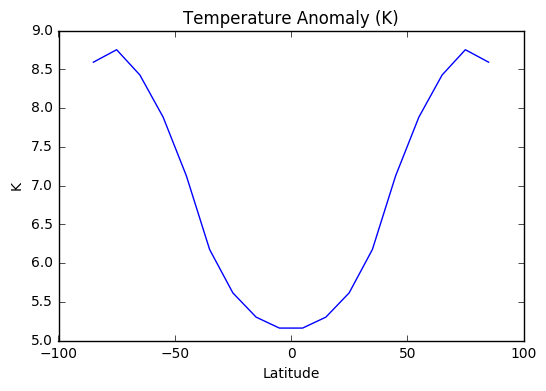

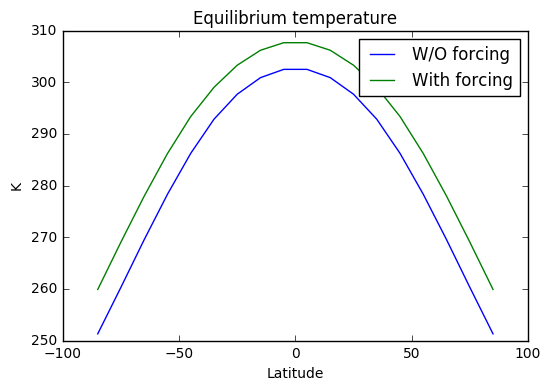

In [1]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

heat_capacity = 2.2 * 10 ** 8     # Heat capacity of water (oceans) and air (J/(m2.K))
earth_radius = 6371 * 1000        # Earth radius in meters
f_2x_co2 = 3.7                    # Radiative forcing due to doubling of CO2 (W/m2)

albedo_min=0.25
albedo_max=0.64
temperature_upper=293
temperature_lower=255
m = (albedo_max - albedo_min) / (temperature_upper - temperature_lower)    # Slope of albedo function (a(t))

def create_grids(delta_lat):
    """
    Creates 2 grids with intervals of `delta_lat`.
    The first grid is edges and the second one is cells.
    """
    return np.linspace(-90, 90, 1 + 180 / delta_lat), np.linspace(-85, 85, 180 / delta_lat)

def lat_circumference(lat_rad):
    """ Calculates circumference at a given latitude """
    return 2 * np.pi * earth_radius * np.cos(lat_rad)    # m


def albedo(temperature):
    """ Calculates albedo using a given temperature """
    if temperature < temperature_lower:
        return albedo_max
    elif temperature > temperature_upper:
        return albedo_min
    else:
        return albedo_min + m * (temperature_upper - temperature)


def K(lat_rad):
    """ Calculates diffusivity for a given latitude (radian) """
    return np.cos(lat_rad) * 2 * 10 ** 5


def f_m_j(delta_temp, delta_lat_rad, lat_rad):
    """ Calculates heat flux density at a given latitude (radian)
        `delta_temp` and `delta_lat_rad` are differences between temperature and latitude of two adjacent cells.
    """
    return (-heat_capacity * K(lat_rad) / earth_radius) * (delta_temp / delta_lat_rad)    # W/m


def solar_radiation(lat_rad):
    """ Calculates incoming solar radiation at a given latitude (radian) """
    return 295 + 125 * np.cos(2 * lat_rad)    # W/m2


def olr_lw_feedback(temperature):
    """ Calculates outgoing longwave radiation for a give temperature (K) """
    return -244 + 1.66 * temperature    # W/m2


def asr(cell_albedo, lat_rad):
    """ Calculates absorbed solar radiation at a given latitude (radian) using the cell albedo """
    return (1 - cell_albedo) * solar_radiation(lat_rad)    # W/m2


def calculate_temperature(
    init_temperature,
    cells,
    edges,
    delta_lat,
    delta_time=10,
    total_steps=3000,
    add_forcing=False,
    ignore_meridional_flux=False
):
    """ Calculates equilibrium temperature.
    
    Input arguments:
        - int_temperature: initial temperature in Kelvin
        - cells: list of cell latitudes
        - edges: list of edge latitudes, corresponding to `cells`
        - delta_lat: latitude interval between cells and edges (degree)
        - delta_time: time step period in days (default: 10 days)
        - total_steps: number of steps to run the model for (default: 3000 steps)
        - add_forcing: boolean stating whether to add forcing to radiative flux
        - ignore_meridional_flux: if set to True, the function doesn't consider meridional flux for calculating equilibrium temperature
    
    Returns a tuple of five items:
        - cells_temperatures: K
        - cells_albedo
        - cells_asr: W/m2
        - cells_olr: W/m2
        - edges_meridional_flux_density: W/m
    """
    delta_time = delta_time * 86400        # convert days to seconds
    
    # convert all degree values to radian
    delta_lat_rad = np.radians(delta_lat)
    cells_rad = np.radians(cells)
    edges_rad = np.radians(edges)
    
    cells_albedo = np.zeros(len(cells))
    cells_asr = np.zeros(len(cells))
    cells_olr = np.zeros(len(cells))
    cells_meridional_flux = np.zeros(len(cells))
    edges_meridional_flux_density = np.zeros(len(edges))
    edges_meridional_flux_density[0] = edges_meridional_flux_density[-1] = 0
    cells_temperatures = np.full(len(cells), init_temperature)

    for i in range(total_steps):
        for idx, cell_lat_rad in enumerate(cells_rad):
            cell_temperature = cells_temperatures[idx]
            
            cells_albedo[idx] = albedo(cell_temperature)
            cells_asr[idx] = asr(cells_albedo[idx], cell_lat_rad)
            cells_olr[idx] = olr_lw_feedback(cell_temperature)
        for j in range(1, len(cells_rad)):
            edges_meridional_flux_density[j] = f_m_j(cells_temperatures[j] - cells_temperatures[j-1], delta_lat_rad, edges_rad[j])
        for idx, cell_lat_rad in enumerate(cells_rad):
            radiative_flux = cells_asr[idx] - cells_olr[idx]
            if not ignore_meridional_flux:
                cells_meridional_flux[idx] = (np.cos(edges_rad[idx+1]) * edges_meridional_flux_density[idx+1] - np.cos(edges_rad[idx]) * edges_meridional_flux_density[idx]) / delta_lat_rad
                radiative_flux += -cells_meridional_flux[idx] / (earth_radius * np.cos(cell_lat_rad))
            if add_forcing:
                radiative_flux += f_2x_co2
            cells_temperatures[idx] = cells_temperatures[idx] + radiative_flux * delta_time / heat_capacity

    return cells_temperatures, cells_albedo, cells_asr, cells_olr, edges_meridional_flux_density

init_temp = 293.0    # Initial temperature for all cells (K)
delta_lat = 10       # Delta latitude (degree)

edges_grid, cells_grid = create_grids(delta_lat)    # Create edge and cell grids from 90S to 90N with intervals of 10 degree

cells_temp, cells_albedo, cells_asr, cells_olr, edges_meridional_flux_density = calculate_temperature(
    init_temp, cells_grid, edges_grid, delta_lat
)
cells_temp_with_forcing, cells_albedo_with_forcing, cells_asr_with_forcing, cells_olr_with_forcing, edges_meridional_flux_density_with_forcing = calculate_temperature(
    init_temp, cells_grid, edges_grid, delta_lat, add_forcing=True
)

plt.title('Temperature Anomaly (K)')
plt.xlabel('Latitude')
plt.ylabel('K')
plt.plot(cells_grid, cells_temp_with_forcing - cells_temp)
plt.show()

plt.title('Equilibrium temperature')
plt.xlabel('Latitude')
plt.ylabel('K')
plt.plot(cells_grid, cells_temp, label='W/O forcing')
plt.plot(cells_grid, cells_temp_with_forcing, label='With forcing')
plt.legend()
plt.show()

b)	Describe and explain the pattern (e.g., what does the plot look like, and why is the temperature change larger in some latitudes).  

_Adding forcing to our model increases equilibrium temperature of the cells. As the `Temperature Anomaly` plot shows, the difference is higher around the poles and is at its lowest around the equator.
Greenhouse effect has a bigger impact at northern and southern latitudes: temperature rise at those areas lead to loss of more ice and a decrease in albedo and OLR. This change in albedo is more dramatic at areas with initial higher albedo (i.e. the poles) and therefore effect of their loss is more noticeable when comparing the two scenarios._

c)	Also plot **and** discuss the albedo, ASR, OLR, and meridional heat flux changes.  

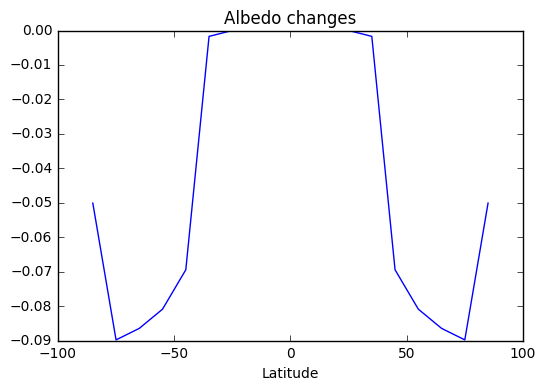

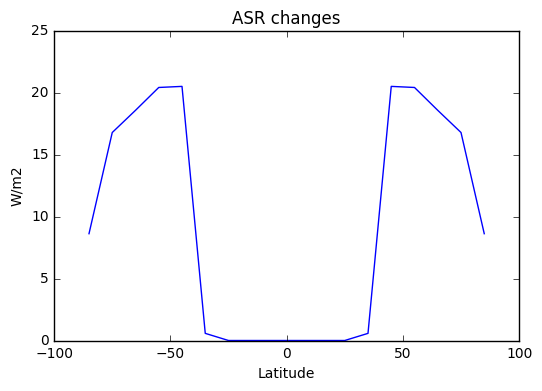

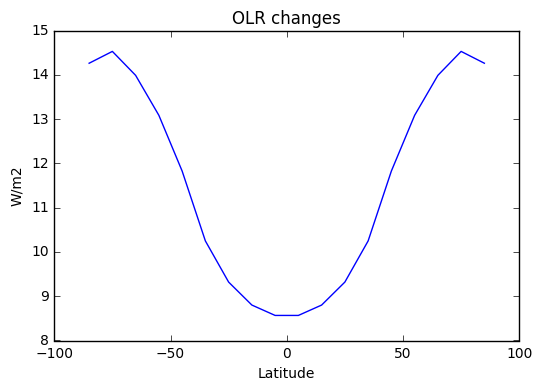

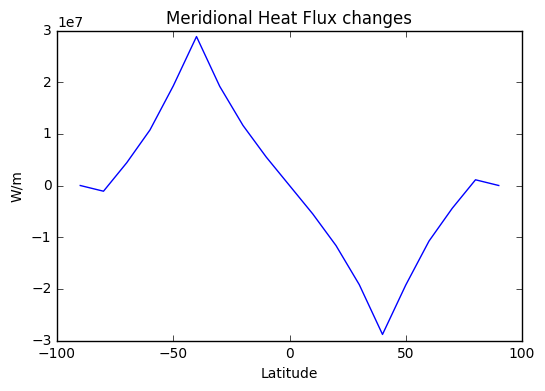

In [2]:
plt.title('Albedo changes')
plt.xlabel('Latitude')
plt.plot(cells_grid, cells_albedo_with_forcing - cells_albedo)
plt.show()

plt.title('ASR changes')
plt.xlabel('Latitude')
plt.ylabel('W/m2')
plt.plot(cells_grid, cells_asr_with_forcing - cells_asr)
plt.show()

plt.title('OLR changes')
plt.xlabel('Latitude')
plt.ylabel('W/m2')
plt.plot(cells_grid, cells_olr_with_forcing - cells_olr)
plt.show()

plt.title('Meridional Heat Flux changes')
plt.xlabel('Latitude')
plt.ylabel('W/m')
plt.plot(edges_grid, edges_meridional_flux_density_with_forcing - edges_meridional_flux_density)
plt.show()

_As mentioned in section `b`, OLR and albedo decrease more around the poles. Lower albedo at those areas means less surface reflection and more absorbed radiation._

d)	How does the global average climate sensitivity compare to that of the simple 0-D model _with the LW feedback_ from earlier?

In [3]:
# Surface area between all edges.
# This array is used as `weights` for `numpy.average` in order to normalize temperature at different latitudes.
bands_surface_areas = 2 * np.pi * (earth_radius ** 2) * np.diff(np.sin(np.radians(edges_grid)))

print('Climate sensitivity: {:0.2f} K'.format(np.average(cells_temp_with_forcing - cells_temp, weights=bands_surface_areas)))

Climate sensitivity: 6.37 K


_Temperature difference is normalized using area of each latitude band. Still climate sensitivity is much higher in this model, i.e. 6.7K comapred to 2.2K in the old model, which makes me think it might be wrong!_

## 2.	

a. Would you expect the 1-D EBM to behave more like advection or diffusion, in terms of its numerical properties?  Explain your answer.  

_It looks more like diffusion. We are dealing with heat transfer from areas with higher concentration of heat/energy to areas with lower concentration._

b. What should the relationship (i.e., the equation) between ∆t and ∆x be in this case to avoid numerical instability?

_$\Delta t <= (\Delta x)^2/2K$_

## 3. Test your hypothesis by running the 1-D EBM with different values of ∆t and ∆x:

Note: Your answer should include a **table** with all the time step/grid point values you used, indicating which combinations were stable and which were unstable. You do not need to include the code for all of the cases in your submitted assignment.

**Describe the steps** you followed such that someone else could repeat what you’ve done.  

a. First, increase the time step until the model just starts to get unstable. Determine this value to the nearest day (or tenth of a day if you want to be more precise). Include a copy of the commented model with the borderline time step here. Plot this equil. temp. as a function of latitude.
   

In [4]:
"""
The model uses 3000 steps for calculating equilibrium temperature for cells with 10 degree intervals.
The closest time step before instability for these conditions is 43 days. The following loop prints average temperature
for five scenarios:
three before instability and two after that. Instability starts at time step greater than 43 days.
As it can be seen in plots in the next section, the final temperatures of cells oscillate dramatically
from one cell to another. 
"""
temp_series = []
print('Time step (days)\tAverage equilibrium temperature (K)')
for delta_t in np.linspace(42, 44, 5):
    cells_temp, cells_albedo, cells_asr, cells_olr, edges_meridional_flux_density = calculate_temperature(
        init_temp, cells_grid, edges_grid, delta_lat, delta_t
    )
    temp_series.append((delta_t, cells_temp))
    print('{:0.2f}\t\t\t{:0.2f}'.format(delta_t, np.average(cells_temp)))

Time step (days)	Average equilibrium temperature (K)
42.00			281.80
42.50			281.80
43.00			281.63
43.50			-455520535743879977202163250102272.00
44.00			-68224376303486059868758517781799029325687138647711340270758920192.00


b. Provide a copy of the commented model and equil. temp. plot for an unstable time step. (You will likely need to limit the number of steps you calculate.)
    

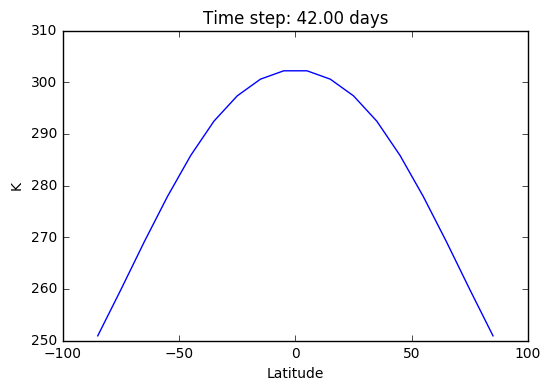

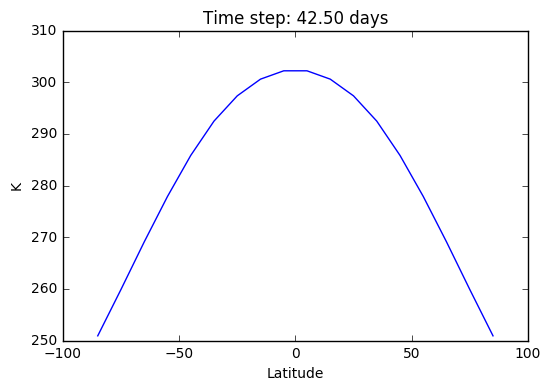

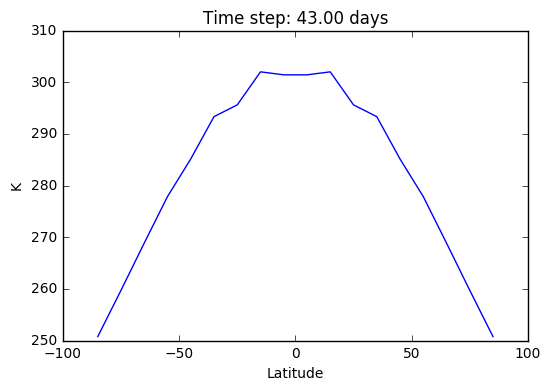

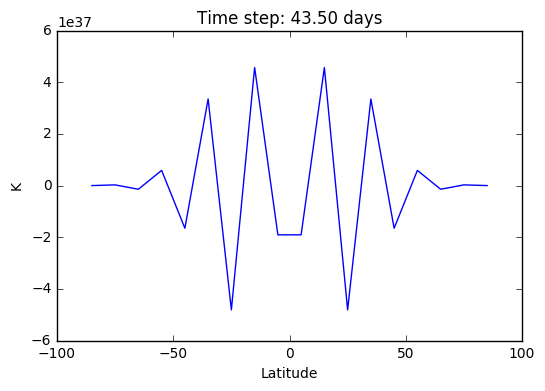

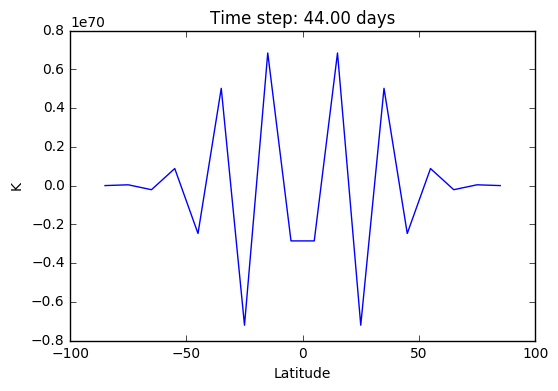

In [5]:
# See description in previous section

for s in temp_series:
    plt.title('Time step: {:0.2f} days'.format(s[0]))
    plt.xlabel('Latitude')
    plt.ylabel('K')
    plt.plot(cells_grid, s[1])
    plt.show()

c. Based on this result and your hypothesis from question 2, what do you expect the unstable time step to be if you double the number of grid points? Explain your answer.
    

_Doubling grid points means halving delta x. Based on the formula in `2b`, unstable time step should happen at about quarter of current value, i.e. ~11 days._

d. Verify this by doubling the number of grid points in your code and trying different values for the time step. Include a borderline time step case (commented code plus equil. temperature plot) for the doubled grid point case.
 

In [6]:
delta_lat_halved = 5
edges_grid_doubled, cells_grid_doubled = create_grids(delta_lat_halved)

temp_series_doubled_grid = []
print('Time step (days)\tAverage equilibrium temperature (K)')
for delta_t in np.linspace(8, 12, 8):
    cells_temp, cells_albedo, cells_asr, cells_olr, edges_meridional_flux_density = calculate_temperature(
        init_temp, cells_grid_doubled, edges_grid_doubled, delta_lat_halved, delta_t
    )
    temp_series.append((delta_t, cells_temp))
    print('{:0.2f}\t\t\t{:0.2f}'.format(delta_t, np.average(cells_temp)))

for s in temp_series_doubled_grid:
    plt.title('Time step: {:0.2f} days'.format(s[0]))
    plt.plot(cells_grid_doubled, s[1])
    plt.show()

Time step (days)	Average equilibrium temperature (K)
8.00			280.04
8.57			279.98
9.14			279.94
9.71			344233870436583150974551628647531546464199221318648476083940010705528528624943104.00
10.29			6772959936232284744276174848389135678843617945650056617783985163127298934486798131075985079984735153150468752980840369461487358877845021106979143737907828739800580208294617470248646311071428075089943828224353480666010771464553326706688.00


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:121: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in double_scalars


10.86			nan
11.43			nan
12.00			nan


e. Do your results support the hypothesis you formed in part 1? Explain your answer.

_The results almost support the hypothesis. The unstable time step occurred at about 10 days._

## 4. Verify that the model converges to the correct solution as ∆x and ∆t ->0, by running the model for increasingly small values of ∆x (you will have to decrease ∆t accordingly).  

a. Save the zonal profiles and plot them together.  The lines should mostly lie on top of each other, especially as ∆x gets small.  

[If you do not see this behavior, verify that you are running the model to equilibrium. As the time step decreases, you need more time steps in order to reach equilibrium.]

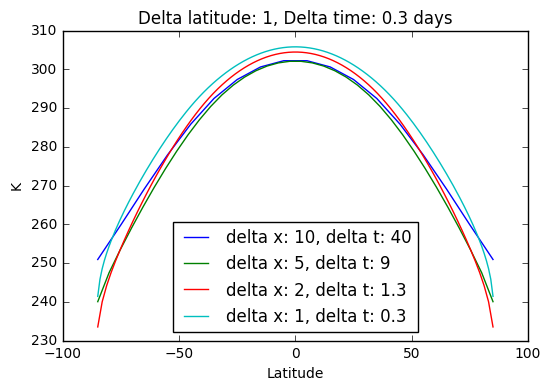

In [7]:
# NOTE: If this cell takes too long to run, comment out the last two plots (delta_x=1 and 2)
"""
The following function calculates equilibrium temperature for given delta_lat and delta_t, using `calculate_temperature`
function defined in the beginning. Delta x and t are decreased together, though time step needs to be decreased more to
keep the model in a stable state. As we decrease time step, total number of steps for running the model must increase,
otherwise the model does not reach equilibrium.
"""
def plot_lat_time(delta_lat, delta_t, total_steps=3000):
    edges_grid, cells_grid = create_grids(delta_lat)
    cells_temp, cells_albedo, cells_asr, cells_olr, edges_meridional_flux_density = calculate_temperature(
        init_temp, cells_grid, edges_grid, delta_lat, delta_t, total_steps=total_steps
    )

    plt.title('Delta latitude: {}, Delta time: {} days'.format(delta_lat, delta_t))
    plt.xlabel('Latitude')
    plt.ylabel('K')
    plt.plot(cells_grid, cells_temp, label='delta x: {}, delta t: {}'.format(delta_lat, delta_t))
    plt.ticklabel_format(useOffset=False)

plot_lat_time(10, 40)
plot_lat_time(5, 9)
plot_lat_time(2, 1.3, total_steps=5000)
plot_lat_time(1, 0.3, total_steps=5000)

plt.legend(loc='best')
plt.show()

b. Explain what is meant by "convergence" in this situation, and describe how you verified that the model converged.

_`Convergence` means getting closer to the true results of our models as we decrease delta x and t._

## Checklist

* Notebook re-runs correctly ("Kernel" -> "Restart and run all" works).
* All variables are commented with short variable decription (if not obvious from variable name) and units.
* Any functions include docstrings or sufficient commenting to describe inputs, outputs, and what it does.
* Include sufficient commenting in code that someone could look at portions and easily understand your methodology.
* Plots include titles, labels (with units) on x and y axes, and legends (if multiple lines). (Titles/legends are not necessary if they convey no more information than x and y axis labels.)
* Numerical values in Markdown or print statements include units.
* Answers to “compare,” “explain,” etc. questions are in complete sentences and grammatically correct. 